# Goal of Analysis:

### 1. find out the customers who bought the most items overall in her lifetime

### 2. for each item, the customer who bought that product the most

### 3. cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. Each item can only belong to one cluster

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
item_to_id = pd.read_csv('item_to_id.csv')
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [3]:
purchase_history = pd.read_csv('purchase_history.csv')
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


### Part 1: find out customers who bought the most items

In [4]:
# the rows are each user, the columns are the items they purchased

purchase_expanded = pd.concat([purchase_history['user_id'], purchase_history['id'].\
                               str.split(',', expand=True)], axis=1).fillna(0)

purchase_expanded

,user_id,0,1,2,3,4,5,6,7,8,...,17,18,19,20,21,22,23,24,25,26
0,222087,27,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1343649,6,47,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,404134,18,12,23,22,27,43,38,20,35,...,0,0,0,0,0,0,0,0,0,0
3,1110200,9,23,2,20,26,47,37,0,0,...,0,0,0,0,0,0,0,0,0,0
4,224107,31,18,5,13,1,21,48,16,26,...,47,12,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39469,704794,48,42,44,10,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39470,31237,23,21,26,27,41,9,47,43,20,...,0,0,0,0,0,0,0,0,0,0
39471,724925,3,39,28,4,1,43,47,27,18,...,0,0,0,0,0,0,0,0,0,0
39472,651509,13,39,20,32,37,1,3,18,34,...,0,0,0,0,0,0,0,0,0,0


In [5]:
import warnings
warnings.filterwarnings('ignore')

# next I will sum up the number of purchase for each user

purchase_sum = purchase_expanded.groupby('user_id').sum()
purchase_sum = purchase_sum.rename(columns={0:'purchase_quantity'})

purchase_sum

,purchase_quantity
user_id,
47,3
68,23
113,46
123,4
223,117
...,...
1499730,45
1499778,3214
1499797,34


In [6]:
purchase_sum['purchase_quantity'].sort_values(ascending=False)

user_id
1148109    991813
1038037        99
562246         99
745575        988
639912         98
            ...  
1381911         1
514469          1
513403          1
717090          1
468254          1
Name: purchase_quantity, Length: 24885, dtype: object

The user with user_id 1148109 bought 991813 items throught his/her lifetime.

### Part 2: for each item, the customer who bought that product the most

In [7]:
purchase_expanded = purchase_expanded.set_index('user_id')
purchase_expanded

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
user_id,,,,,,,,,,,,,,,,,,,,,
222087,27,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1343649,6,47,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404134,18,12,23,22,27,43,38,20,35,1,...,0,0,0,0,0,0,0,0,0,0
1110200,9,23,2,20,26,47,37,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224107,31,18,5,13,1,21,48,16,26,2,...,47,12,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704794,48,42,44,10,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31237,23,21,26,27,41,9,47,43,20,40,...,0,0,0,0,0,0,0,0,0,0
724925,3,39,28,4,1,43,47,27,18,25,...,0,0,0,0,0,0,0,0,0,0


In [8]:
item_with_user = purchase_expanded.astype('int').apply(np.argmax, axis=0).reset_index()
item_user_most = item_with_user.rename(columns={'index': 'Item_id', 0: 'User_id'})

df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')
df = df[['Item_id', 'Item_name', 'User_id']]
df.iloc[1:,:]

,Item_id,Item_name,User_id
1,1,sugar,160
2,2,lettuce,14
3,3,pet items,63
4,4,baby items,190
5,5,waffles,53
6,6,poultry,4
7,7,sandwich bags,105
8,8,butter,248
9,9,soda,18
10,10,carrots,97


### Part 3: Item clustering

In [9]:
# define the feature matrix: item_id, user_id
feature = purchase_expanded.T
feature.head()

user_id,222087,1343649,404134,1110200,224107,409803,1296632,748280,31625,987613,...,1494796,587211,755085,922812,1055933,704794,31237,724925,651509,517744
0,27,6,18,9,31,43,18,14,1,27,...,38,13,18,46,9,48,23,3,13,39
1,26,47,12,23,18,29,15,43,43,1,...,2,39,21,35,43,42,21,39,39,40
2,0,17,23,2,5,8,31,6,31,3,...,44,34,17,0,15,44,26,28,20,20
3,0,0,22,20,13,37,11,20,37,2,...,43,27,47,0,3,10,27,4,32,3
4,0,0,27,26,1,23,20,7,25,11,...,46,11,6,0,44,2,41,1,37,10


#### I will need to use elbow method to determine the best numer of clusters before fitting the clustering model

In [10]:
# choose best K - number of clusters
inertias = []

ks = range(1,10)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feature)   
    inertias.append(kmeans.inertia_)

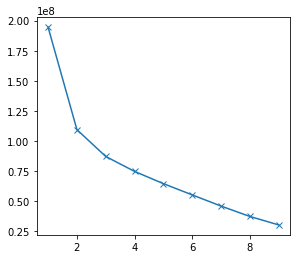

In [11]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(ks,inertias,marker='x')

it seems that the number of clusters should be 4

#### fit the model

In [12]:
kmeans = KMeans(n_clusters=4, random_state=42)
label = kmeans.fit_predict(feature)
label

array([2, 2, 2, 2, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

#### model visualization

I will need to reduce the dimension in order to visualize my clustering results

In [13]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

In [14]:
filtered_label0 = pca_feature[label == 0]
filtered_label1 = pca_feature[label == 1]
filtered_label2 = pca_feature[label == 2]
filtered_label3 = pca_feature[label == 3]

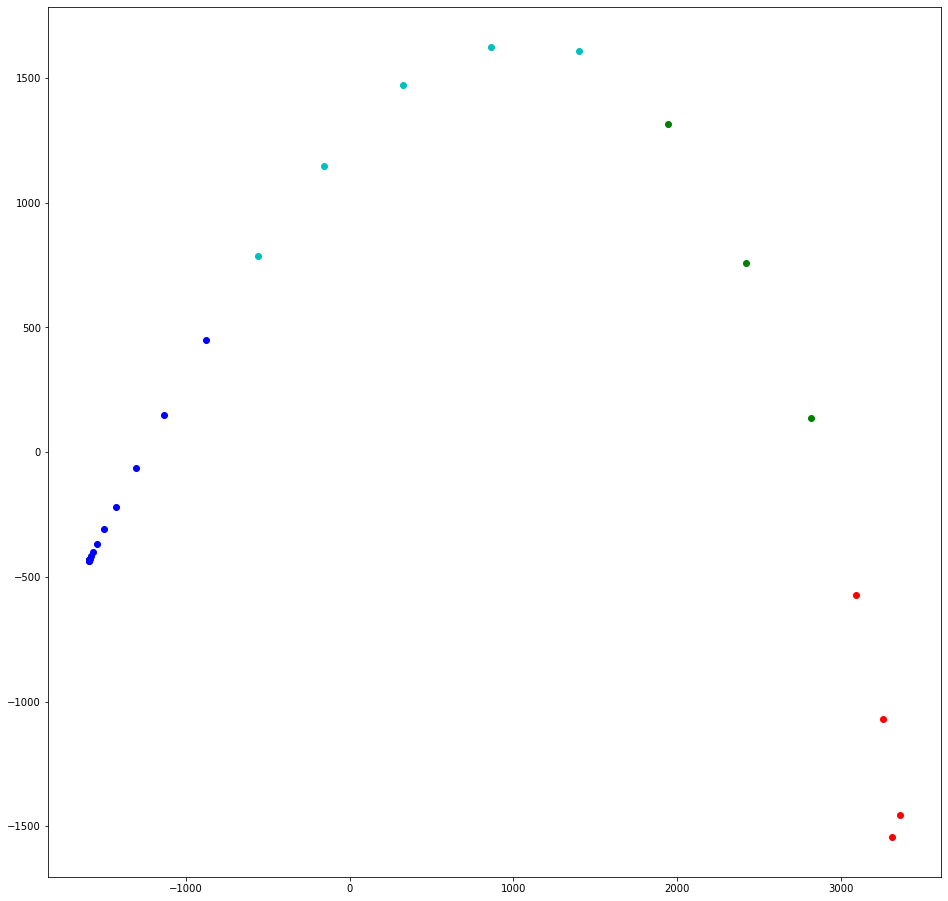

In [15]:
# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']

plt.show()